# Analysis of the speedups provided by similarity search module

In this notebook, we will explore the gains in time and memory of the different methods we use in the similarity search module.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from aeon.similarity_search.series import DummySNN, MassSNN
from aeon.utils.numba.general import sliding_mean_std_one_series

ggplot_styles = {
    "axes.edgecolor": "white",
    "axes.facecolor": "EBEBEB",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "white",
    "grid.linewidth": "1.2",
    "xtick.color": "555555",
    "xtick.major.bottom": True,
    "xtick.minor.bottom": False,
    "ytick.color": "555555",
    "ytick.major.left": True,
    "ytick.minor.left": False,
}

plt.rcParams.update(ggplot_styles)

## Computing means and standard deviations for all subsequences

When we want to compute a normalised distance, given a time series `X` of size `m` and a query `q` of size `l`, we have to compute the mean and standard deviation for all subsequences of size `l` in `X`. One could do this task by doing the following:

In [2]:
def rolling_window_stride_trick(X, window):
    """
    Use strides to generate rolling/sliding windows for a numpy array.

    Parameters
    ----------
    X : numpy.ndarray
        numpy array
    window : int
        Size of the rolling window

    Returns
    -------
    output : numpy.ndarray
        This will be a new view of the original input array.
    """
    a = np.asarray(X)
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def get_means_stds(X, query_length):
    """Compute the means and standard deviations of rolling windows in a time series."""
    windows = rolling_window_stride_trick(X, query_length)
    return windows.mean(axis=-1), windows.std(axis=-1)


rng = np.random.default_rng(12)
size = 100
query_length = 10

# Create a random series with 1 feature and 'size' timesteps
X = rng.random((1, size))
means, stds = get_means_stds(X, query_length)
print(means.shape)

(1, 91)


One issue with this code is that it actually recompute a lot of information between the computation of mean and std of each windows. Suppose that the window we compute the mean for `W_i = {x_i, ..., x_{i+(l-1)}`, to do this, we sum all the elements and divide them by `l`. You then want to compute the mean for `W_{i+1} = {x_{i+1}, ..., x_{i+1+(l-1)}`, which shares most of its values with `W_i` expect for `x_i` and `x_{i+1+(l-1)`. 

The optimization here consists in keeping a rolling sum, we only compute the full sum of the `l` values for the first window `W_0`, then to obtain the sum for `W_1`, we remove `x_0` and add `x_{1+(l-1)}` from the sum of `W_0`. We can also a rolling squared sum to compute the standard deviation.

The `sliding_mean_std_one_series` function implement the computation of the means and standard deviations using these two rolling sums. The last argument indicates the dilation to apply to the subsequence, which is not used here, hence the value of 1 in the code bellow.

In [3]:
sizes = [500, 1000, 5000, 10000, 25000, 50000]
query_lengths = [50, 100, 250, 500]
times = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["size", "query_length"])
)
# A first run for numba compilations if needed
sliding_mean_std_one_series(rng.random((1, 50)), 10, 1)
for size in sizes:
    for query_length in query_lengths:
        X = rng.random((1, size))
        _times = %timeit -r 3 -n 3 -q -o get_means_stds(X, query_length)
        times.loc[(size, query_length), "full computation"] = _times.average
        _times = %timeit -r 3 -n 3 -q -o sliding_mean_std_one_series(X, query_length, 1)
        times.loc[(size, query_length), "sliding_computation"] = _times.average

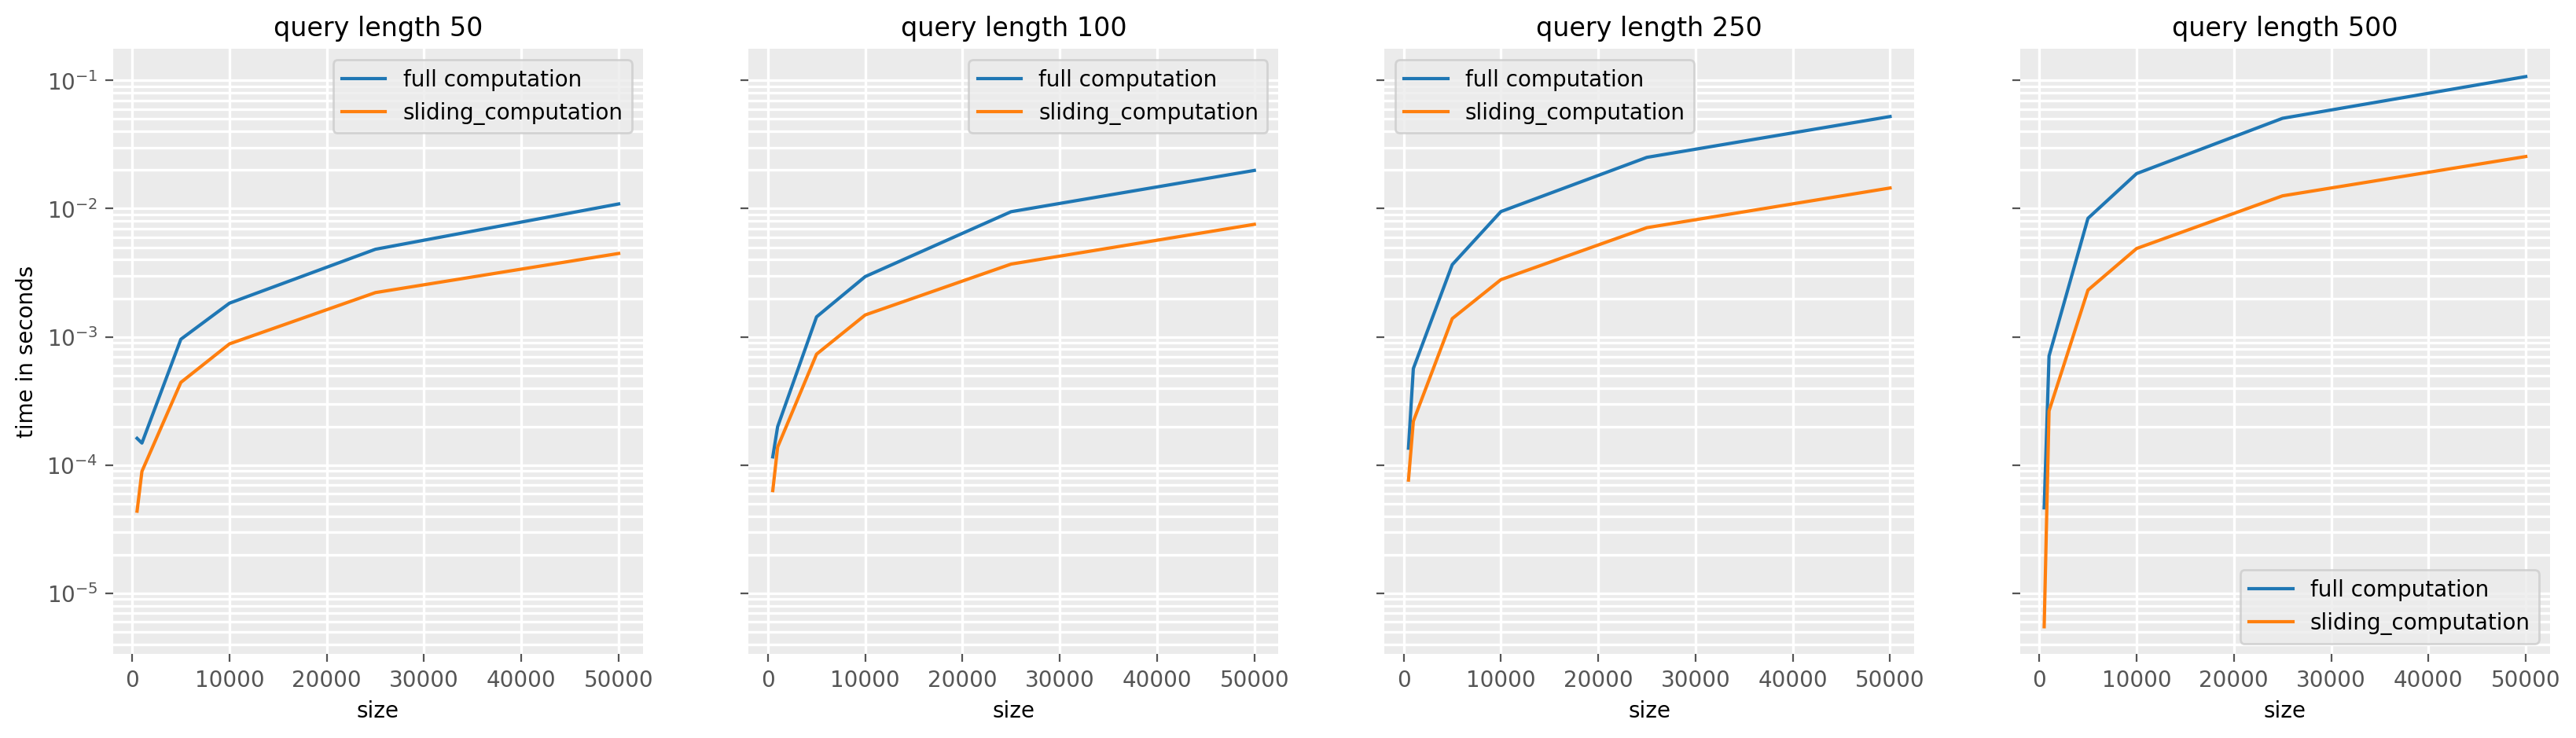

In [4]:
fig, ax = plt.subplots(ncols=len(query_lengths), figsize=(20, 5), dpi=200, sharey=True)
for j, (i, grp) in enumerate(times.groupby("query_length")):
    grp.droplevel(1).plot(label=i, ax=ax[j])
    ax[j].set_title(f"query length {i}")
    ax[j].set_yscale("log")
ax[0].set_ylabel("time in seconds")
plt.show()

As you can see, the larger the size of `q`, the greater the speedups. This is because the larger the size of `q`, the more recomputation we avoid by using a sliding sum.

## Computing the Euclidean distance with a dot product obtained from convolution

The standard way to compute the (squared) euclidean distance between a query `Q = {q_1, ..., q_l}` and a candidate subsequence `W_i = {x_i, ..., x_{i+(l-1)}` is to compute it as $d(Q,W_i) = \sum_j^l (x_{i+j} - q_j)^2$.

We can also express this distance as $d(Q,W_i) = Q^2 + W_i^2 - 2Q.W_i$, in our case, we can use the fact a cross corelation can be used to compute $Q*X$ to obtain the dot products between $Q$ and all $W_i$. The timing difference become even more important for large input, when it becomes worth to use a fast Fourrier transform to compute the convolution in the frequency domain. See scipy.signal.convolve documentation for more information.

In [5]:
sizes = [500, 1000, 5000, 10000, 20000, 30000, 50000]
query_lengths = [0.01, 0.05, 0.1, 0.2]
times = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["size", "query_length"])
)

for size in sizes:
    for _query_length in query_lengths:
        query_length = int(_query_length * size)
        X = rng.random((1, size))
        q = rng.random((1, query_length))
        mask = np.ones((1, size - query_length + 1), dtype=bool)
        # Used for numba compilation before timings
        mass = MassSNN(length=query_length).fit(X)
        mass.compute_distance_profile(q)
        dummy = DummySNN(length=query_length).fit(X)
        dummy.compute_distance_profile(q)

        _times = %timeit -r 3 -n 3 -q -o dummy.compute_distance_profile(q)
        times.loc[(size, _query_length), "Naive Euclidean distance"] = _times.average

        _times = %timeit -r 3 -n 3 -q -o mass.compute_distance_profile(q)
        times.loc[(size, _query_length), "Euclidean distance with MASS"] = (
            _times.average
        )

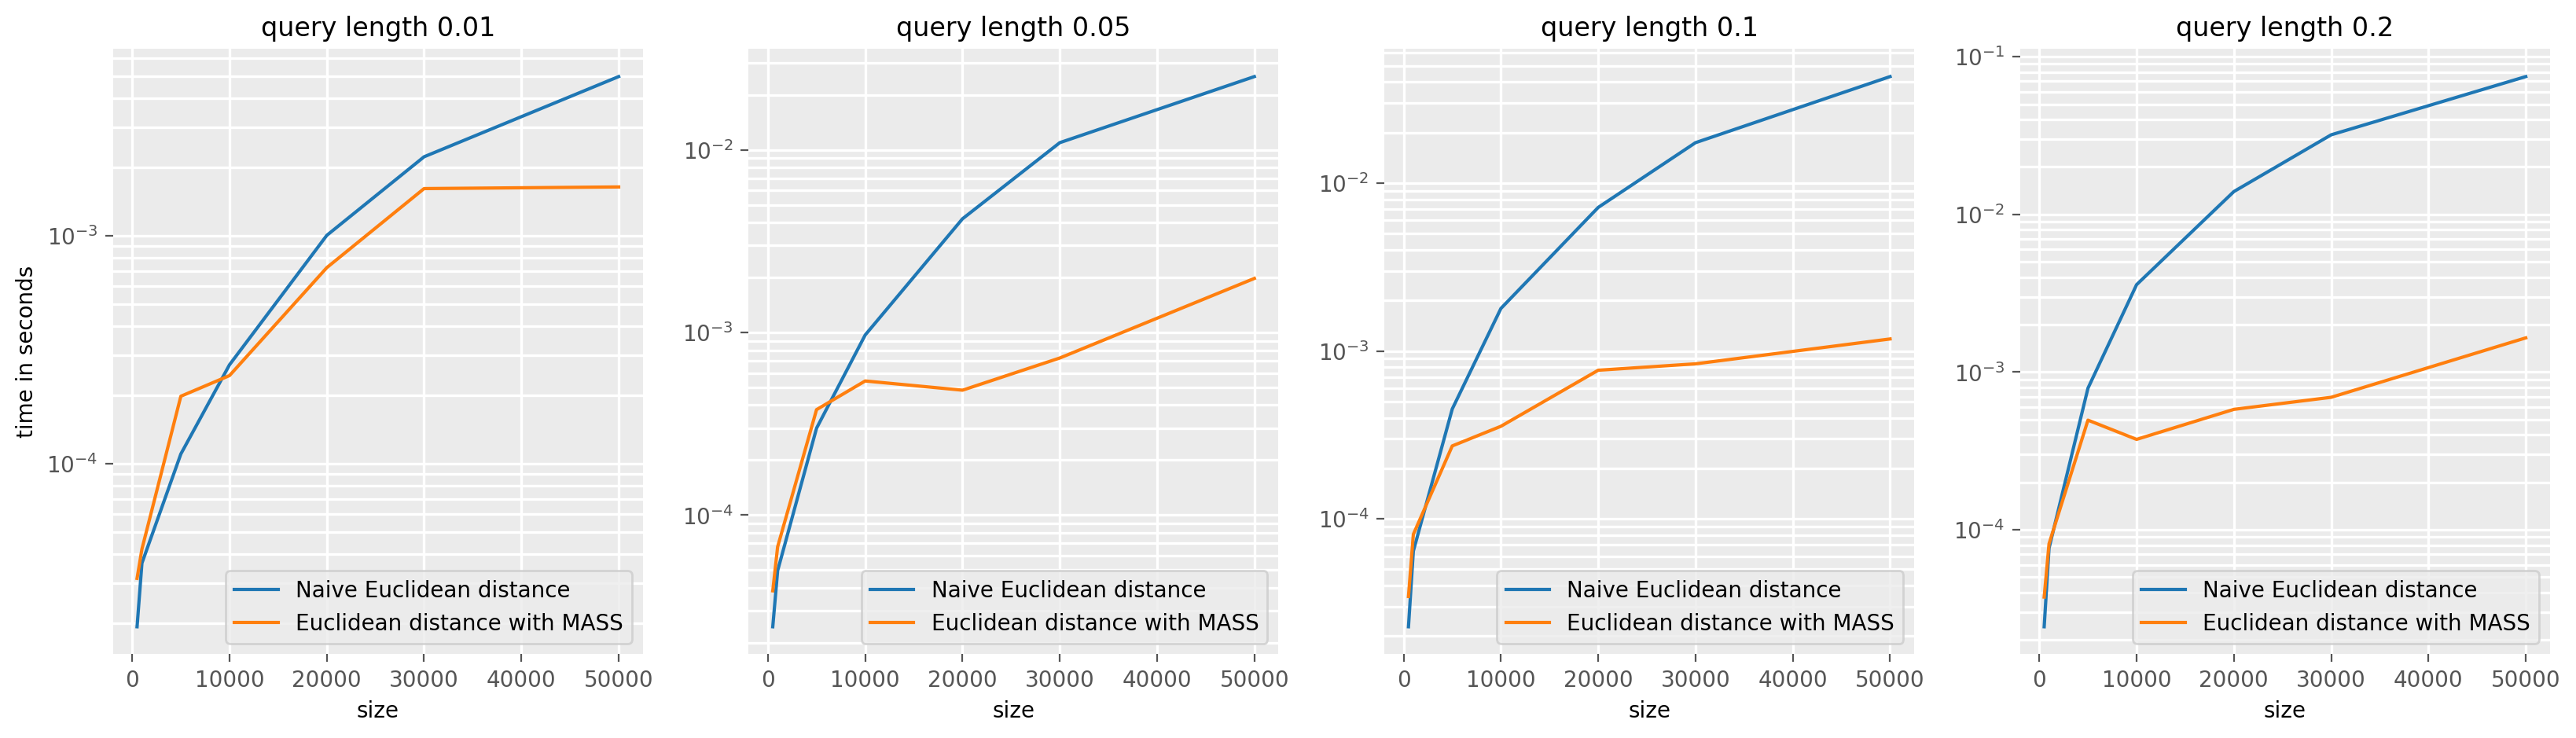

In [6]:
fig, ax = plt.subplots(ncols=len(query_lengths), figsize=(20, 5), dpi=200)
for j, (i, grp) in enumerate(times.groupby("query_length")):
    grp.droplevel(1).plot(label=i, ax=ax[j])
    ax[j].set_title(f"query length {i}")
    ax[j].set_yscale("log")
ax[0].set_ylabel("time in seconds")

plt.show()

The same reasoning holds for the normalised (squared) euclidean distance, we can use the `normalize` parameter of the two estimators to set this option. In the normalised case, the formula used to computed the normalised (squared) euclidean distance is taken from the paper [Matrix Profile I: All Pairs Similarity Joins for Time Series](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf), see MASS algortihm.

In [7]:
sizes = [500, 1000, 5000, 10000, 20000, 30000, 50000]
query_lengths = [0.01, 0.05, 0.1, 0.2]
times = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["size", "query_length"])
)

for size in sizes:
    for _query_length in query_lengths:
        query_length = int(_query_length * size)
        X = rng.random((1, size))
        q = rng.random((1, query_length))
        mask = np.ones((1, size - query_length + 1), dtype=bool)
        # Used for numba compilation before timings
        mass = MassSNN(length=query_length, normalize=True).fit(X)
        mass.compute_distance_profile(q)
        dummy = DummySNN(length=query_length, normalize=True).fit(X)
        dummy.compute_distance_profile(q)

        _times = %timeit -r 3 -n 3 -q -o dummy.compute_distance_profile(q)
        times.loc[(size, _query_length), "Naive Normalised Euclidean distance"] = (
            _times.average
        )

        _times = %timeit -r 3 -n 3 -q -o mass.compute_distance_profile(q)
        times.loc[(size, _query_length), "Normalised Euclidean distance with MASS"] = (
            _times.average
        )

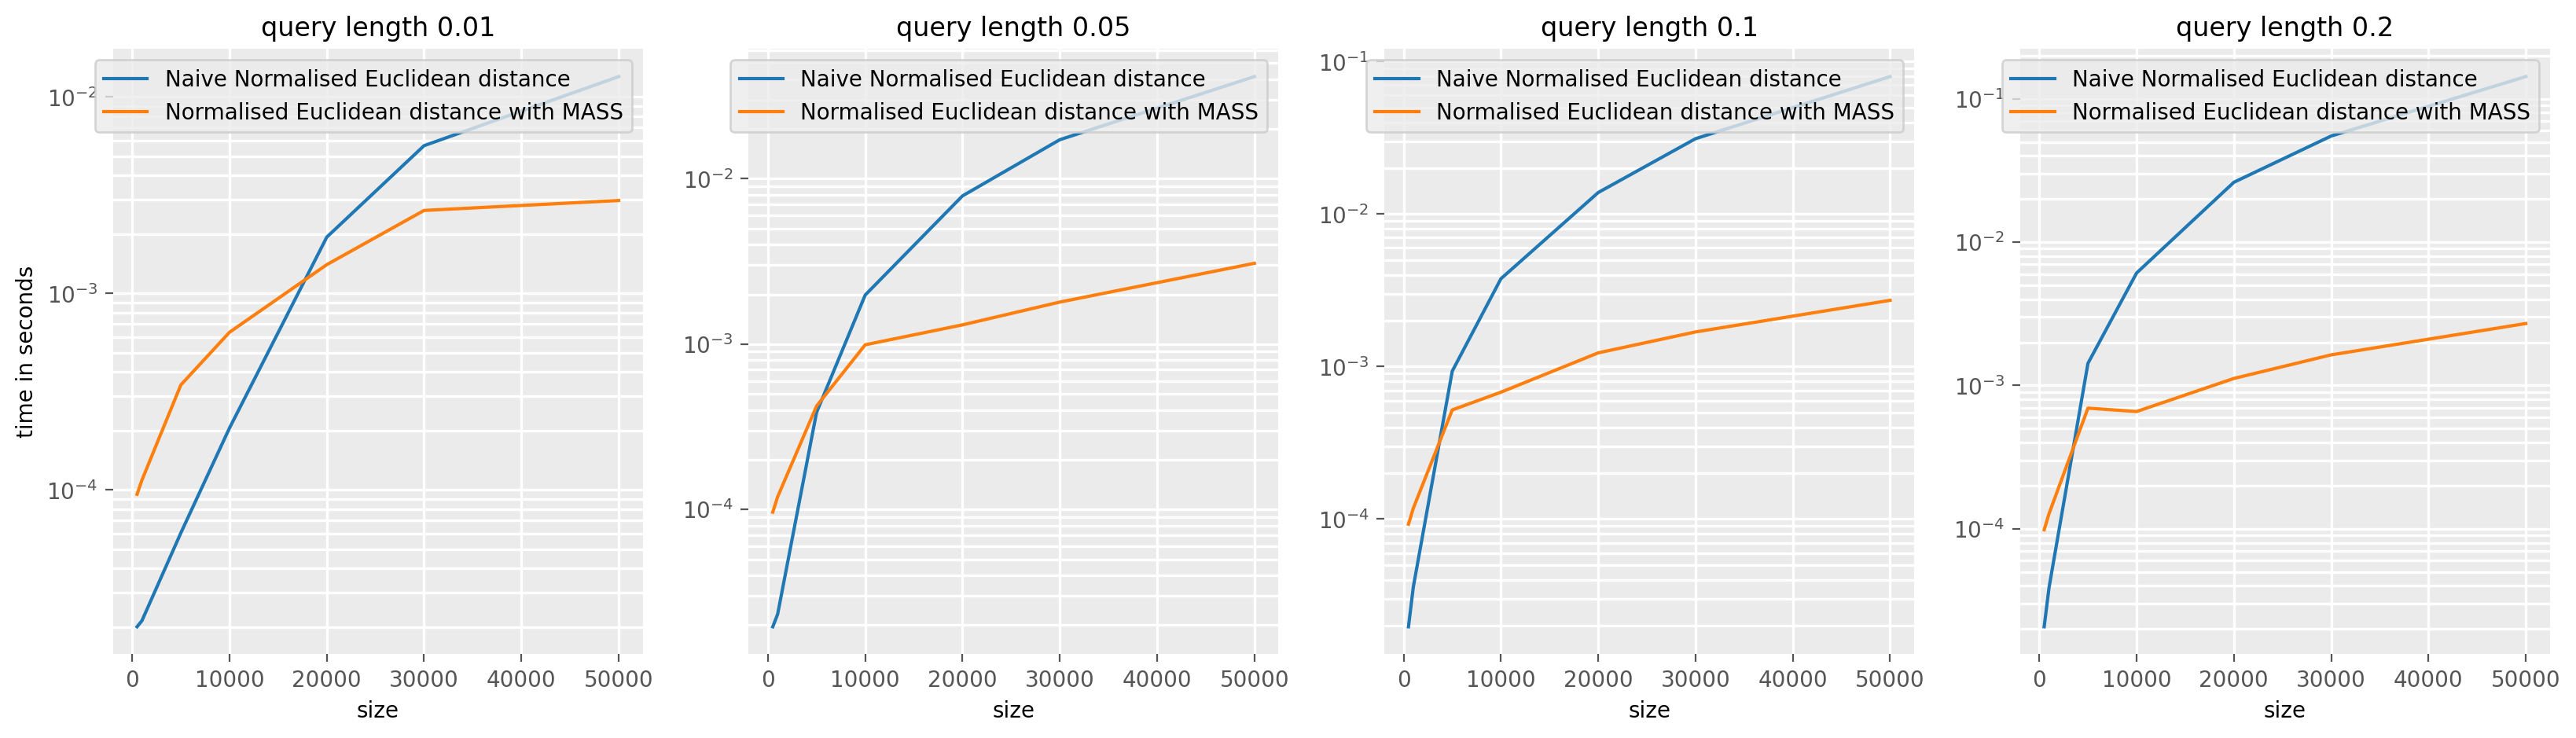

In [8]:
fig, ax = plt.subplots(ncols=len(query_lengths), figsize=(20, 5), dpi=200)
for j, (i, grp) in enumerate(times.groupby("query_length")):
    grp.droplevel(1).plot(label=i, ax=ax[j])
    ax[j].set_title(f"query length {i}")
    ax[j].set_yscale("log")
ax[0].set_ylabel("time in seconds")
plt.show()

## Updating the dot products used in MASS when computing matrix profiles

This is part of the STOMP algorithm, which update the dot products of the sliding query instead of recomputing it everytime. When you compute $MASS(X,q_i)$, and $q_i$ is taken from a series $Y$ such as $q_i = Y[i:i+L]$, you can compute the dot product of $q_0$, and then only update it for subsequent $q_1, ...$

In [9]:
from aeon.similarity_search.series._commons import (
    _update_dot_products,
    get_ith_products,
)


def compute_all_products(X, T, L):
    """
    Compute dot products for all subsequences between two time series.

    This function computes the dot products between subsequences of `X` and `T`
    for a given query length `L`. It iterates over the subsequences in `T` and
    calls `get_ith_products` to calculate the dot product with `X`.
    """
    for i in range(T.shape[1] - L + 1):
        prods = get_ith_products(X, T, L, i)
    return prods


def update_products(X, T, L):
    """
    Update dot products incrementally for all subsequences between two time series.

    This function first computes the dot products between the first subsequence of
    `X` and `T`.Then, it updates these dot products iteratively for each subsequent
    subsequence in `T`.
    """
    prods = get_ith_products(X, T, L, 0)
    for i in range(T.shape[1] - L + 1):
        prods = _update_dot_products(X, T, prods, L, i)
    return prods


sizes = [500, 1000, 5000, 10000]
query_lengths = [0.01, 0.05, 0.1]
times = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["size", "query_length"])
)

for size in sizes:
    for _query_length in query_lengths:
        query_length = int(_query_length * size)
        X = rng.random((1, size))
        T = rng.random((1, size))
        search_space_size = size - query_length + 1
        mask = np.ones((1, search_space_size), dtype=bool)
        # Used for numba compilation before timings
        compute_all_products(X, T, query_length)
        update_products(X, T, query_length)

        _times = %timeit -r 2 -n 2 -q -o compute_all_products(X, T, query_length)
        times.loc[(size, _query_length), "compute_all_products"] = _times.average

        _times = %timeit -r 2 -n 2 -q -o update_products(X, T, query_length)
        times.loc[(size, _query_length), "update_products"] = _times.average

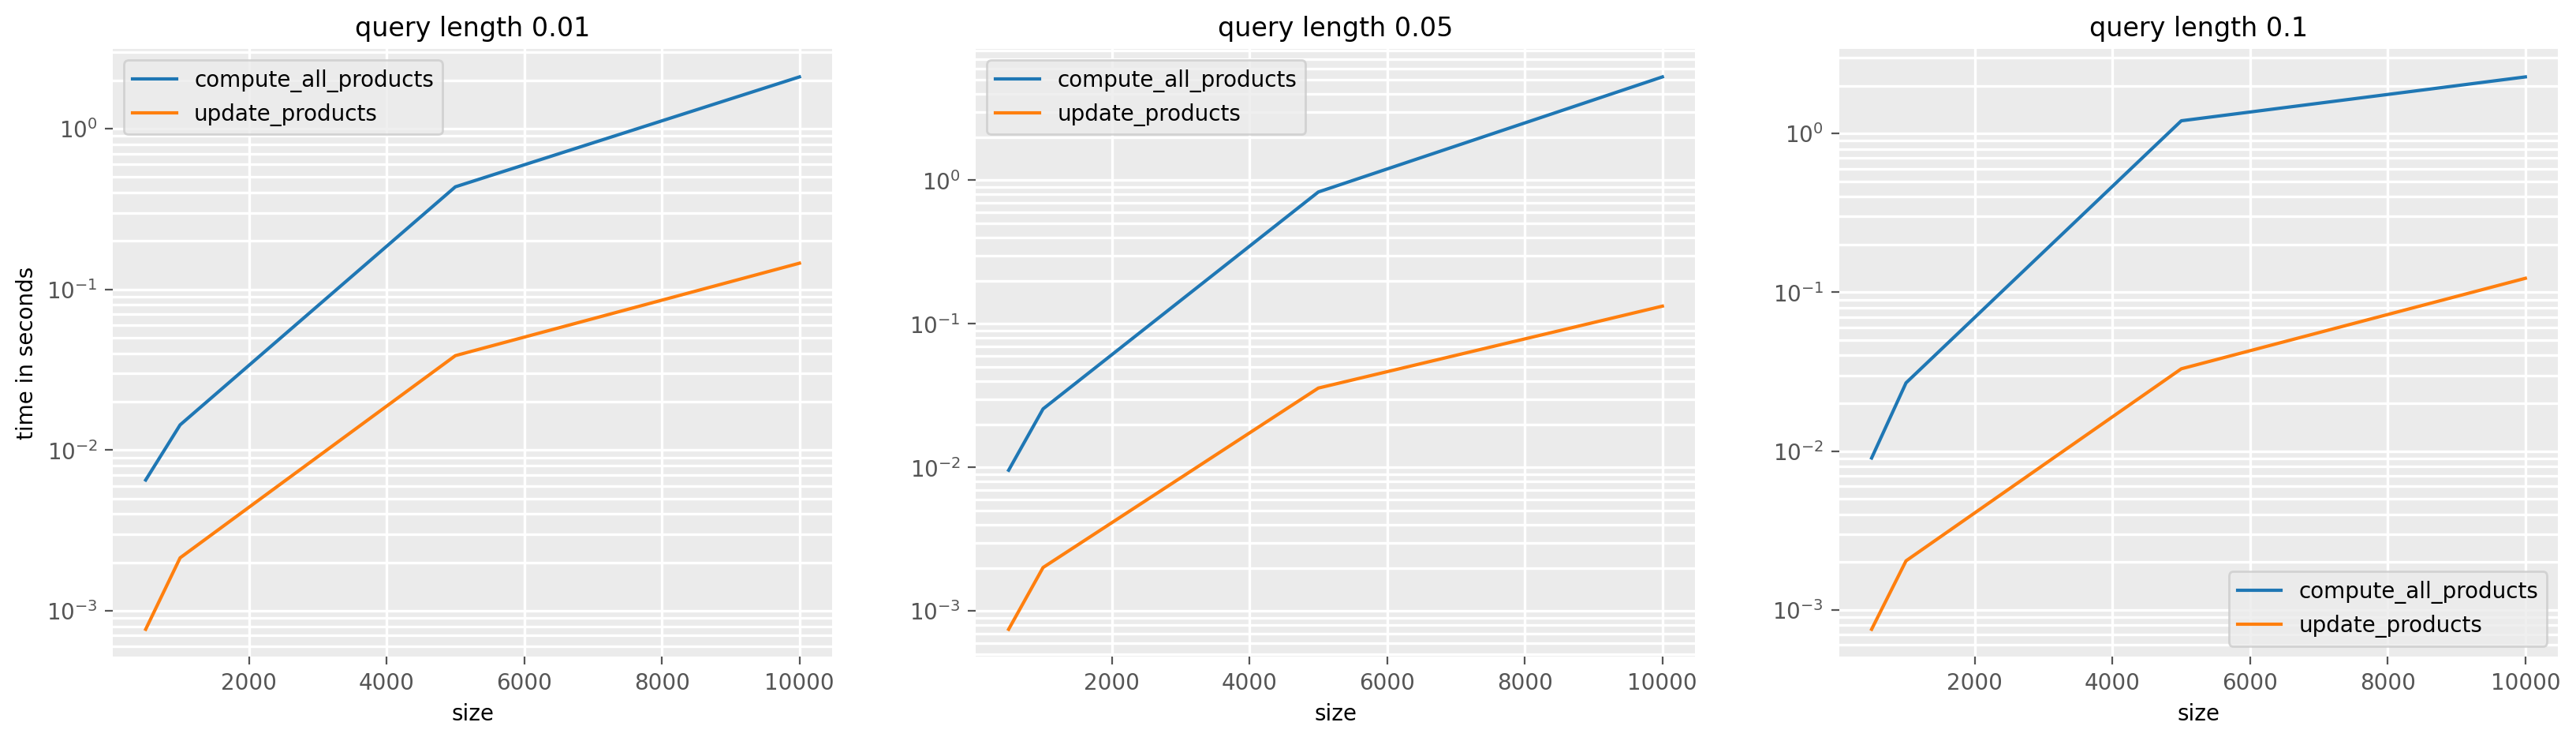

In [10]:
fig, ax = plt.subplots(ncols=len(query_lengths), figsize=(20, 5), dpi=200)
for j, (i, grp) in enumerate(times.groupby("query_length")):
    grp.droplevel(1).plot(label=i, ax=ax[j])
    ax[j].set_title(f"query length {i}")
    ax[j].set_yscale("log")
ax[0].set_ylabel("time in seconds")
plt.show()